In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
with np.load('input/mnist.npz', allow_pickle=True) as f: 
    train_x, train_y = f['x_train'], f['y_train']
    test_x, test_y = f['x_test'], f['y_test']
print(train_x.shape, train_y.shape)

(60000, 28, 28) (60000,)


label is 4


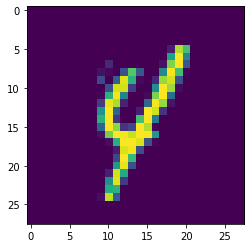

In [3]:
index = 3457
print('label is %d' % train_y[index])
plt.imshow(train_x[index])
plt.show()

In [4]:
np.min(train_x[index]), np.max(train_x[index]), np.mean(train_x[index])

(0, 255, 19.855867346938776)

In [5]:
train_x_1 = train_x.reshape(len(train_x), -1)
print(train_x_1.shape)

test_x_1 = test_x.reshape(len(test_x), -1)
print(test_x_1.shape)

(60000, 784)
(10000, 784)


In [10]:
class DummyClassifier(object):
    def __init__(self):
        self.name = 'Dummy'
    def fit(self, train_x, train_y):
        pass
    def predict(self, test_x):
        return np.random.randint(low=0, high=10, size=len(test_x))

In [12]:
classifier = DummyClassifier()
classifier.fit(train_x_1, train_y)
pred = classifier.predict(test_x_1)

In [13]:
def accuracy(pred, gt):
    return np.sum(pred == gt)/len(gt)

In [14]:
acc = accuracy(pred, test_y)
print(acc)

0.1101


In [15]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(pred, test_y)

0.1101

In [17]:
from sklearn.neighbors import KNeighborsClassifier

In [18]:
results = []
for k in range(1,10, 2):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_x_1[:2000], train_y[:2000])
    pred = classifier.predict(test_x_1[:100])
    acc = accuracy_score(pred, test_y[:100])
    results.append(acc)
    print(k, acc)

1 0.86
3 0.9
5 0.9
7 0.89
9 0.9


In [19]:
results = []
for k in range(1,10, 2):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_x_1[:3000], train_y[:3000])
    pred = classifier.predict(test_x_1[:100])
    acc = accuracy_score(pred, test_y[:100])
    results.append(acc)
    print(k, acc)

1 0.89
3 0.94
5 0.93
7 0.9
9 0.9


In [20]:
results = []
for k in range(1,10, 2):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(train_x_1[:10000], train_y[:10000])
    pred = classifier.predict(test_x_1[:100])
    acc = accuracy_score(pred, test_y[:100])
    results.append(acc)
    print(k, acc)

1 0.92
3 0.95
5 0.95
7 0.94
9 0.96


In [22]:
from sklearn.cluster import KMeans

In [23]:
km = KMeans(n_clusters=20)
km.fit(train_x_1[:10000])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
for cluster in km.cluster_centers_:
    plt.imshow(cluster.reshape(28,28))
    plt.show()

#### Задача 1

Подобрать оптимальные параметры для KNeighborsClassifier.
В качестве решения необходимо отправить код подбора параметров в этом ноутбуке seminar03_knn.ipynb и параметры лучшего классификатора knn_best_params.pkl

#### Задача 2

Найти 10 эталонов, чтобы качество классификации было максимальным. (Преодолеть 70%)

В качестве решения необходимо отправить код поиска эталонов в этом ноутбуке seminar03_knn.ipynb и файл с 10 эталонами knn_10_best.npy


#### Задача 3*

Сколько эталонов нужно, чтобы преодолеть 90% точность?
Задача не является обязательной, в качестве решения необходимо предоставить код с решением

#### Ноутбук с решением необходимо сдать отправить боту @ml2021sharebot c пометкой seminar03

### Решение задачи 1

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
# Setup classifier
classifier = KNeighborsClassifier()

In [9]:
# Setup params search
params_grid = { 'n_neighbors': list(range(1, 10, 2)), \
                'weights': ['distance'], \
                'algorithm': ['kd_tree', 'ball_tree'] }
res = GridSearchCV(classifier, params_grid, cv=3, refit=True)

In [11]:
# Fit
frac = len(train_x) // 10
res.fit(train_x_1[:frac], train_y[:frac])

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['distance'], 'algorithm': ['kd_tree', 'ball_tree']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
# Score
res.score(test_x_1, test_y)

0.9383

In [14]:
# Save best params
with open("output/knn_best_params.pkl", "wb") as f:
    pickle.dump(res.best_estimator_.get_params(), f)

### Решение задачи 2

In [14]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import accuracy_score

In [7]:
# Setup cluster search
# nc = NearestCentroid()
km = KMeans(n_clusters=10)

In [8]:
# Setup training data
np.random.seed(123)
frac = len(train_x_1) // 10
train_x_2 = np.empty((0, 784), dtype='int')
train_y_2 = np.empty(0, dtype='int')
for i in range(10):
    indices_ = np.argwhere(train_y == i).flatten()
    indices = np.random.choice(indices_, frac // 10)
    train_x_2 = np.concatenate((train_x_2, train_x_1[indices]))
    train_y_2 = np.concatenate((train_y_2, train_y[indices]))

Class 2


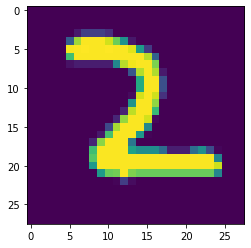

In [9]:
ind = 1200
print('Class', train_y_2[ind])
plt.imshow(train_x_2[ind].reshape(28, 28))
plt.show()

In [10]:
# Fit
# nc.fit(train_x_1[:frac], train_y[:frac])
samples = np.array(range(frac)) # np.random.choice(len(train_x_1), frac)
# km.fit(train_x_1[:frac])
km.fit(train_x_2[samples])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# Get cluster centers' classes
centerClasses = []
for i in range(10):
    indices = np.argwhere(km.labels_ == i).flatten()
    classes = train_y_2[samples[indices]]
    centerClasses.append(np.argmax(np.bincount(classes)))

print(centerClasses)

[1, 8, 4, 6, 5, 7, 2, 0, 3, 1]


Class 1


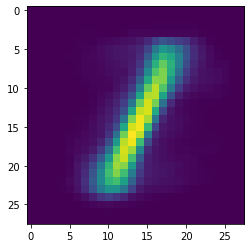

Class 8


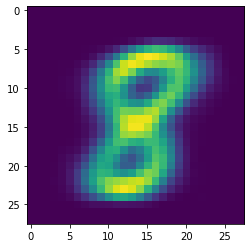

Class 4


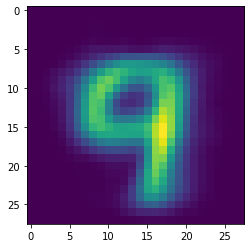

Class 6


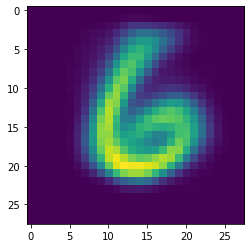

Class 5


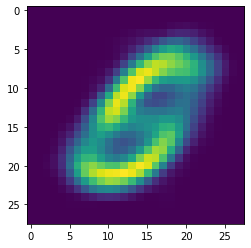

Class 7


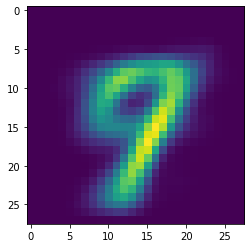

Class 2


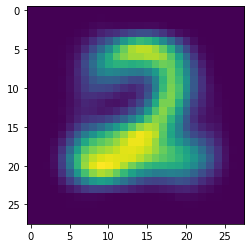

Class 0


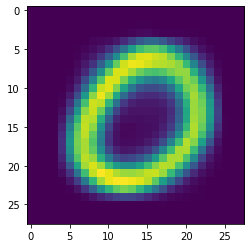

Class 3


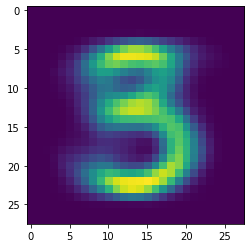

Class 1


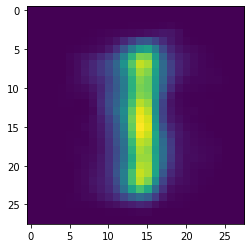

In [12]:
# Show centroids
# for i in range(len(nc.centroids_)):
#     print('Class', nc.classes_[i])
#     plt.imshow(nc.centroids_[i].reshape((28, 28)))
#     plt.show()

# Show clusters
for i in range(len(km.cluster_centers_)):
    print('Class', centerClasses[i])
    plt.imshow(km.cluster_centers_[i].reshape(28, 28))
    plt.show()

In [15]:
# Setup classifier
classifier = KNeighborsClassifier(n_neighbors=1, weights='distance')

In [16]:
# Fit
classifier.fit(km.cluster_centers_, centerClasses)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=1, p=2,
           weights='distance')

In [17]:
# Score
# nc.score(test_x_1, test_y)
# classifier.score(test_x_1, test_y)
pred = classifier.predict(test_x_1)
acc = accuracy_score(pred, test_y)
print(acc)

0.5898


In [34]:
etalons_10 = np.zeros((10, 784))
np.save('knn_10_best', etalons_10)

### Решение задачи 3

In [2]:
# ваше решение задачи 3